In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [2]:
df.shape

(3276, 10)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [4]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [5]:
df= df.dropna()

<Axes: ylabel='Potability'>

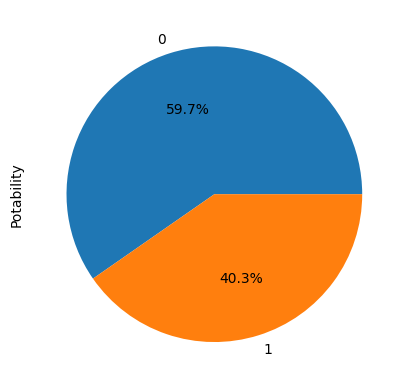

In [6]:
#Plots
import matplotlib.pyplot as plt
import seaborn as sns


df.Potability.value_counts().plot(kind ='pie', autopct='%1.1f%%')

In [7]:
zero  = df[df['Potability']==0]   #zero values in Potability column
one = df[df['Potability']==1]  # one values in Potability column
from sklearn.utils import resample
#minority class that  is 1, we need to upsample/increase that class so that there is no bias
#n_samples = 1998 means we want 1998 sample of class 1, since there are 1998 samples of class 0
df_minority_upsampled = resample(one, replace = True, n_samples = 1200) 
#concatenate
df = pd.concat([zero, df_minority_upsampled])

from sklearn.utils import shuffle
df = shuffle(df) # shuffling so that there is particular sequence

<Axes: ylabel='Potability'>

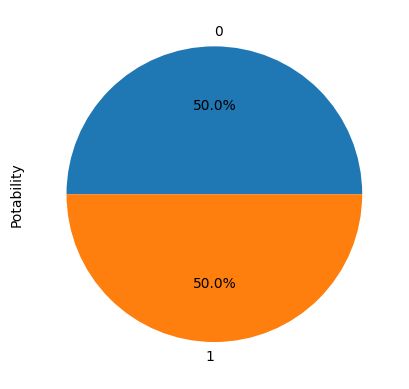

In [8]:
df.Potability.value_counts().plot(kind ='pie',autopct='%1.1f%%')

In [9]:
X = df.drop(['Potability'], axis = 1)
y = df['Potability']

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
features= X.columns
X[features] = sc.fit_transform(X[features])

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1)

In [12]:
xgb =XGBClassifier(eval_metric = 'logloss', use_label_encoder=False)

params_xgb = {'n_estimators': [50,100,250,400,600,800,1000], 'learning_rate': [0.2,0.5,0.8,1]}
rs_xgb =  RandomizedSearchCV(xgb, param_distributions=params_xgb, cv=5)

In [13]:
#rs_xgb.fit(X_train, y_train)
#print("Best parameters for XGBoost:", rs_xgb.best_params_)

In [14]:
xgb = XGBClassifier(n_estimators= 250, learning_rate= 0.8)

In [15]:
classifiers = [('XGBoost', xgb)]

In [21]:
from sklearn.metrics import accuracy_score

for classifier_name, classifier in classifiers:
 
    # Fit clf to the training set
    classifier.fit(X_train, y_train)    
   
    # Predict y_pred
    pred_xgb = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,pred_xgb)
    

   
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.4f}'.format(classifier_name, accuracy))

XGBoost : 0.8458


In [17]:
print(classification_report(y_test,pred_xgb))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       121
           1       0.81      0.91      0.85       119

    accuracy                           0.85       240
   macro avg       0.85      0.85      0.85       240
weighted avg       0.85      0.85      0.85       240



<Axes: >

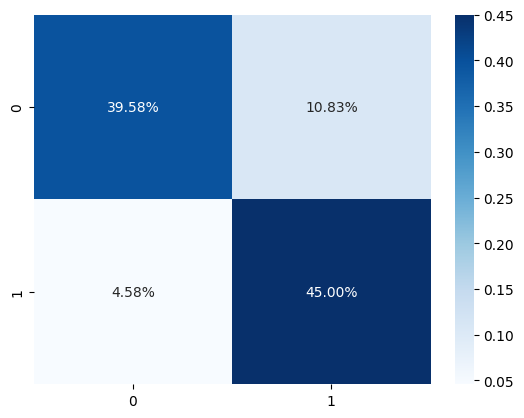

In [18]:
# confusion Maxtrix
cm4 = confusion_matrix(y_test, pred_xgb)
sns.heatmap(cm4/np.sum(cm4), annot = True, fmt=  '0.2%', cmap = 'Blues')

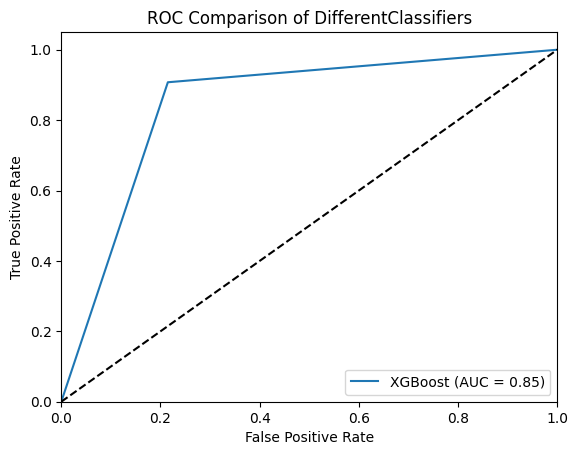

In [19]:
from sklearn.metrics import roc_auc_score,roc_curve

#calculate the ROC AUC score for each model
roc_auc_xgb = roc_auc_score(y_test, pred_xgb)

#get the fpr and tpr for each model
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, pred_xgb)

#plot the ROC curve for each model
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)

#plot the random guessing line
plt.plot([0, 1], [0, 1], 'k--')

#set the plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison of DifferentClassifiers')
plt.legend(loc="lower right")
plt.show()

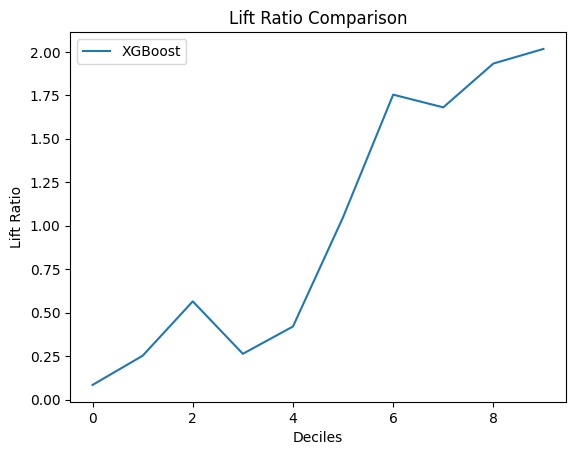

In [20]:
# function to calculate lift ratio for a given model
def calculate_lift_ratio(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    df = X_test.copy()
    df['predictions'] = y_pred_proba
    df['target'] = y_test
    df.sort_values('predictions', ascending=False, inplace=True)
    df['decile'] = pd.qcut(df['predictions'], q=10, labels=False, duplicates='drop')
    overall_positive_rate = df['target'].mean()
    decile_positive_rate = df.groupby(['decile'])['target'].mean()
    lift = decile_positive_rate / overall_positive_rate
    return lift

# define the models
xgb = XGBClassifier()

# calculate lift ratios for each model

lift_ratio_xgb = calculate_lift_ratio(xgb, X_train, X_test, y_train, y_test)
# plot the lift ratio for each model
plt.figure()
plt.plot(lift_ratio_xgb, label='XGBoost')
plt.xlabel('Deciles')
plt.ylabel('Lift Ratio')
plt.title('Lift Ratio Comparison')
plt.legend()
plt.show()